# Introduction
A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become cancer, with melanoma being the deadliest skin cancer. Its incidence has increased during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for skin cancer detection have been proposed in the last years (non-invasive computer-aided diagnosis (CAD) ).

## Goal of the challenge
The goal of this challenge is to classify dermoscopic images of skin lesions among eight different diagnostic classes:
1. Melanoma
2. Melanocytic nevus
3. Basal cell carcinoma
4. Actinic keratosis
5. Benign keratosis
6. Dermatofibroma
7. Vascular lesion
8. Squamous cell carcinoma
In order to do that, you will extract features such as the Asymmetry, the Border irregularity, the Colour and the Dimension of the lesion (usually called the ABCD rule). After that, you will use machine learning algorithms to classify the images.

# Libraries

In [103]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2

from skimage.io import imread
from skimage.segmentation import chan_vese, watershed
from skimage.draw import ellipse
from scipy import ndimage as ndi
from sklearn.cluster import KMeans
from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [104]:
train_directory = './Train/Train'
test_directory = './Test/Test'

# Data
You will use a data-set of 25331 dermoscopic images of skin lesions with, when available, their relative segmentation and metadata (age, sex and anatomical position). Data has already been randomly split into a training-validation set (75%) and a test set (25%). You only have the classification (made by clinicians) of the training-validation set. The goal of the project is to estimate the correct class of each dermoscopic image in the test set. **You can only use the data provided in this challenge**



### Data Load

In [105]:
# Load the data
train_data = pd.read_csv('metadataTrain.csv')
test_data = pd.read_csv('metadataTest.csv')


In [106]:
# Load the images
train_images_filenames = os.listdir(train_directory)
test_images_filenames = os.listdir(test_directory)

train_images_filenames = sorted(train_images_filenames)
test_images_filenames = sorted(test_images_filenames)

train_images = []
train_masks = []
test_images = []
test_masks = []

#Give me the code to put the images in the lists, the masks in the other lists, the mask are the images that finish with _seg.png
for image in train_images_filenames:
    if image.endswith('_seg.png'):
        #Save the name whitout the _seg.png and the image
        train_masks.append([image[:-8], imread(train_directory + '/' + image)])
    else:
        #Save the name without the .png and the image
        train_images.append([image[:-4], imread(train_directory + '/' + image)])
        
for image in test_images_filenames:
    if image.endswith('_seg.png'):
        #Save the name whitout the _seg.png and the image
        test_masks.append([image[:-8], imread(test_directory + '/' + image)])
    else:
        #Save the name without the .png and the image
        test_images.append([image[:-4], imread(test_directory + '/' + image)])



In [107]:
# ################BORRAR ESTA CELDA######
# # Load the images
# train_images_filenames = os.listdir(train_directory)
# test_images_filenames = os.listdir(test_directory)

# train_images_filenames = sorted(train_images_filenames)
# test_images_filenames = sorted(test_images_filenames)

# train_images = []
# train_masks = []
# test_images = []
# test_masks = []

# for image in train_images_filenames:
#     if image.endswith('_seg.png'):
#         # Save the name without the _seg.png and the image
#         name = image[:-8]
#         image_name = name + '.jpg'
#         mask_image = imread(train_directory + '/' + image)
#         image_image = imread(train_directory + '/' + image_name)
#         train_masks.append([name, mask_image])
#         train_images.append([name, image_image])
   
# for image in test_images_filenames:
#     if image.endswith('_seg.png'):
#         # Save the name without the _seg.png and the image
#         name = image[:-8]
#         image_name = name + '.jpg'
#         mask_image = imread(test_directory + '/' + image)
#         image_image = imread(test_directory + '/' + image_name)
#         test_masks.append([name, mask_image])
#         test_images.append([name, image_image])

In [108]:
# import random
# ######BORRAR ESTA CELDA#######

# # Load the images
# train_images_filenames = os.listdir(train_directory)
# test_images_filenames = os.listdir(test_directory)

# train_images_filenames = sorted(train_images_filenames)
# test_images_filenames = sorted(test_images_filenames)

# train_images = []
# train_masks = []
# test_images = []
# test_masks = []

# for image in train_images_filenames[:101]:
#     if image.endswith('_seg.png'):
#         # Save the name without the _seg.png and the image
#         train_masks.append([image[:-8], imread(train_directory + '/' + image)])
#     else:
#         # Save the name without the .png and the image
#         train_images.append([image[:-4], imread(train_directory + '/' + image)])

# for image in test_images_filenames[:101]:
#     if image.endswith('_seg.png'):
#         # Save the name without the _seg.png and the image
#         test_masks.append([image[:-8], imread(test_directory + '/' + image)])
#     else:
#         # Save the name without the .png and the image
#         test_images.append([image[:-4], imread(test_directory + '/' + image)])


# train_images_sample = random.sample(range(4000, len(train_images_filenames)), 400)
# test_images_sample = random.sample(range(4000, len(test_images_filenames)), 400)

# for i in train_images_sample:
#     image = train_images_filenames[i]
#     if image.endswith('_seg.png'):
#         # Save the name without the _seg.png and the image
#         train_masks.append([image[:-8], imread(train_directory + '/' + image)])
#     else:
#         # Save the name without the .png and the image
#         train_images.append([image[:-4], imread(train_directory + '/' + image)])

# for i in test_images_sample:
#     image = test_images_filenames[i]
#     if image.endswith('_seg.png'):
#         # Save the name without the _seg.png and the image
#         test_masks.append([image[:-8], imread(test_directory + '/' + image)])
#     else:
#         # Save the name without the .png and the image
#         test_images.append([image[:-4], imread(test_directory + '/' + image)])

## Data Analysis

### Text Features

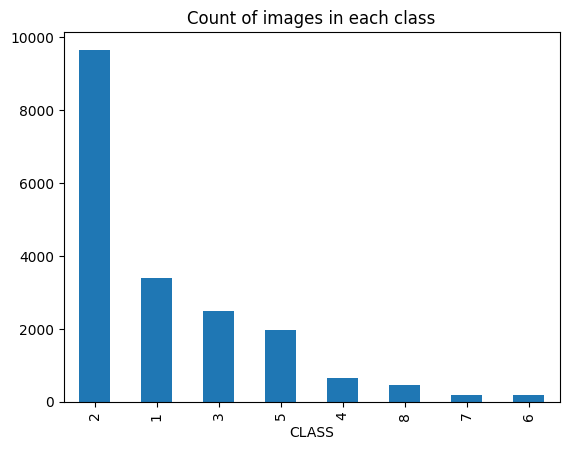

In [109]:
# Value counts of the classes
train_data['CLASS'].value_counts().plot(kind='bar')
plt.title('Count of images in each class')
plt.show()

In [110]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18998 entries, 0 to 18997
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        18998 non-null  object 
 1   CLASS     18998 non-null  int64  
 2   SEX       18714 non-null  object 
 3   AGE       18674 non-null  float64
 4   POSITION  17028 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 742.2+ KB


In [111]:
# Description of the data 
train_data.describe(include='object')

,ID,SEX,POSITION
count,18998,18714,17028
unique,18998,2,8
top,ISIC_0028766,male,anterior torso
freq,1,9978,5194


In [112]:
train_data.describe()

,CLASS,AGE
count,18998.000000,18674.000000
mean,2.568323,53.991914
std,1.532728,18.094209
min,1.000000,0.000000
25%,2.000000,40.000000
50%,2.000000,55.000000
75%,3.000000,70.000000
max,8.000000,85.000000


In [113]:
test_data.describe(include='object')

,ID,SEX,POSITION
count,6333,6233,5672
unique,6333,2,8
top,ISIC_0055289,male,anterior torso
freq,1,3308,1721


In [114]:
test_data.describe()

,AGE
count,6220.000000
mean,54.138264
std,18.241916
min,0.000000
25%,40.000000
50%,55.000000
75%,70.000000
max,85.000000


### Image Features

In [115]:
#Count images loaded
print(f'Number of training images: {len(train_images)}')
print(f'Number of training masks: {len(train_masks)}')

print(f'Number of testing images: {len(test_images)}')
print(f'Number of testing masks: {len(test_masks)}')
    

Number of training images: 18998
Number of training masks: 1945
Number of testing images: 6333
Number of testing masks: 648


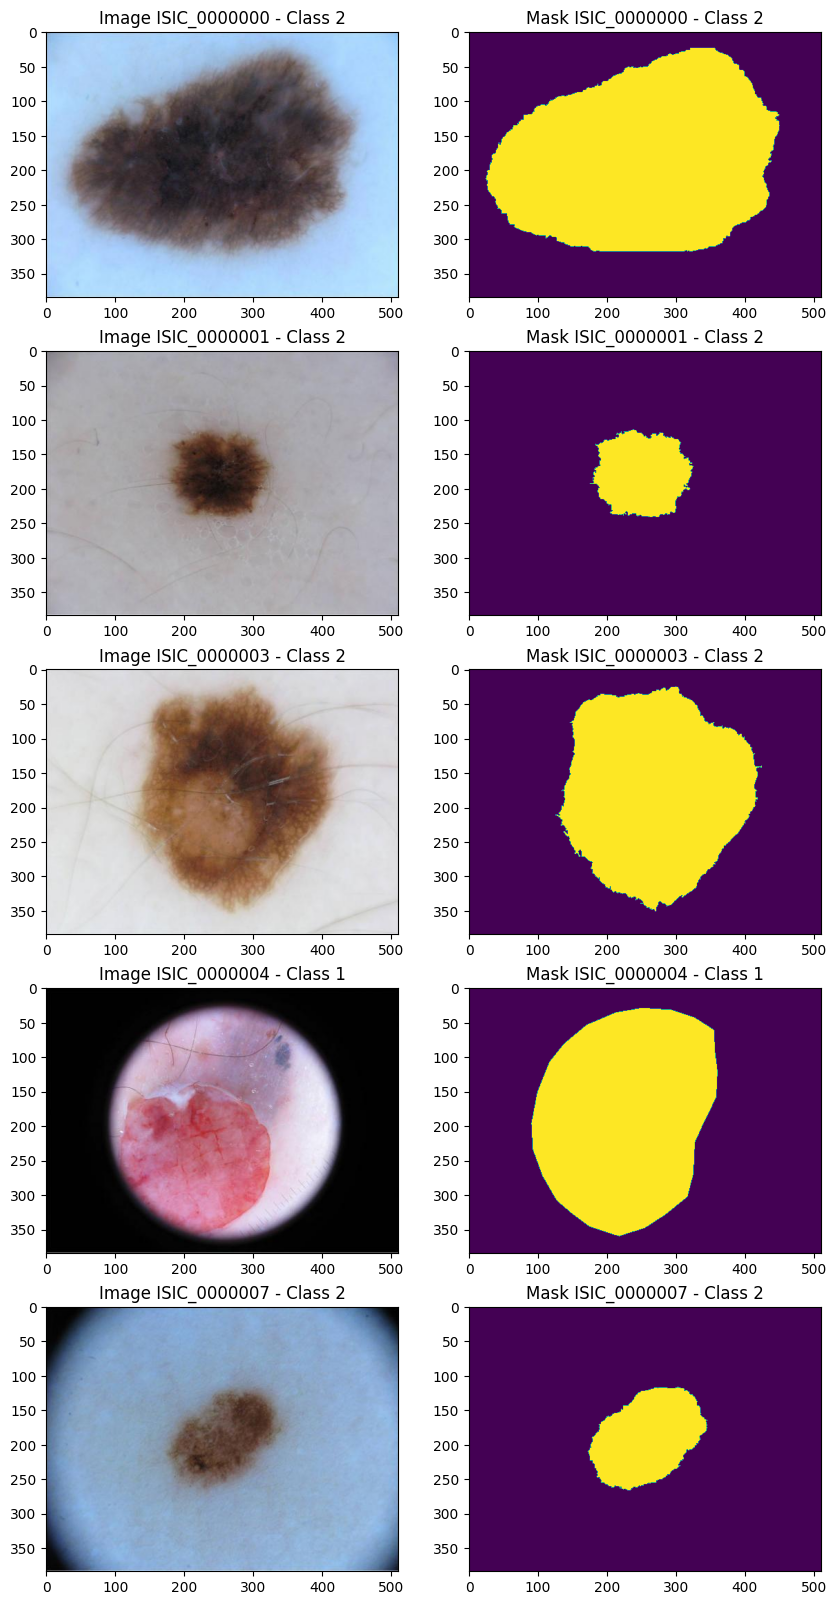

In [116]:
# Display a few images with the corresponding masks the corresponding masks have the same id as the image and their class

# Display the first 5 images
fig, ax = plt.subplots(5, 2, figsize=(10, 20))

#get the first 5 masks
first_5_masks = [mask[0] for mask in train_masks[:5]]

j = 0
for i in first_5_masks:
    #Get the image
    image = next((item for item in train_images if item[0] == i), None)
    #Get the mask
    mask = next((item for item in train_masks if item[0] == i), None)
    
    #Get the class
    class_ = train_data[train_data['ID'] == i]['CLASS'].values[0]
    
    #Plot the image
    ax[j, 0].imshow(image[1])
    ax[j, 0].set_title(f'Image { image[0] } - Class {class_}')
    
    #Plot the mask
    ax[j, 1].imshow(mask[1])
    ax[j, 1].set_title(f'Mask {mask[0]} - Class {class_}')

    j += 1


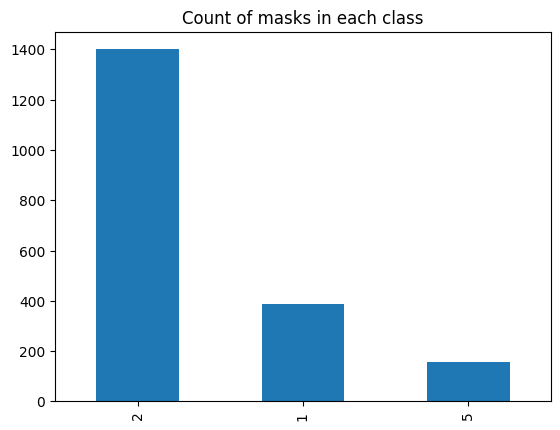

In [117]:
# Value counts of the classes in the masks

#Get the classes of the masks
masks_classes = [train_data[train_data['ID'] == mask[0]]['CLASS'].values[0] for mask in train_masks]

#Plot the classes
pd.Series(masks_classes).value_counts().plot(kind='bar')
plt.title('Count of masks in each class')
plt.show()


# Image Processing
You can use all features you'd like. A list of references describing very well-known features can be found at the end of this page but you can find many more articles in the Literature. You can use Pubmed, Google Scholar or simply Google to look for them.


## Image Preprocessing

In [118]:
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

#Convert the image from RGB to grayscale.
train_images= [[image[0], image[1], get_grayscale(image[1])] for image in train_images]
test_images= [[image[0], image[1], get_grayscale(image[1])] for image in test_images]

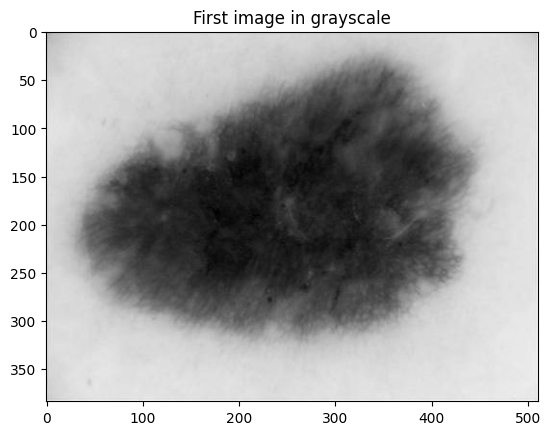

In [119]:
# Display the first image
plt.imshow(train_images[0][2], cmap='gray')
plt.title('First image in grayscale')
plt.show()

In [120]:
def preprocess_black_background(image):
    
    # Threshold the image to get the background mask
    # Adjust the threshold value '10' if needed to properly capture the black background
    _, background_mask = cv2.threshold(image, 10, 255, cv2.THRESH_BINARY_INV)
    
    # Optionally, apply some morphological operations to clean up the mask
    kernel = np.ones((15, 15), np.uint8)
    background_mask = cv2.morphologyEx(background_mask, cv2.MORPH_DILATE, kernel, iterations=2)
    

    # Set the background to a neutral color, for example, mid-gray (127) in Gray
    neutral_color = np.array([127], dtype=np.uint8)
    
    # Create an output image where the background is set to the neutral color
    output_image = image.copy()
    output_image[background_mask == 255] = np.array([np.mean(image[background_mask != 255])], dtype=np.uint8)
  
    return output_image, background_mask


In [121]:
def get_ellipse_mask(image,mask):
    
    #draw the ellipse
    rows, cols = image.shape

    #create the ellipse
    ellipse_draw = ellipse(rows//2, cols//2, rows//2, cols//2)

    y = ellipse_draw[0]
    x = ellipse_draw[1]

    ellipse_image = np.ones_like(image)

    #fill the ellipse
    for i in range(len(x)):
        ellipse_image[y[i], x[i]] = 0

    image[ellipse_image > 0] = np.array([np.mean(image[mask != 255])], dtype=np.uint8)

    return image

In [122]:
def get_gaussian_blur(image, kernel=13):
    image, mask = preprocess_black_background(image)
    image = get_ellipse_mask(image, mask)
    return cv2.GaussianBlur(image, (kernel, kernel), 0), mask

def get_median_blur(image):
    image, mask = preprocess_black_background(image)
    image = get_ellipse_mask(image, mask)
    return cv2.medianBlur(image, 7), mask

def get_filtered_image(image):
        return [image[0], image[1], image[2], get_gaussian_blur(image[2])]

def joblib_filter(images):
    return Parallel(n_jobs=-2, verbose=1)(delayed(get_filtered_image)(image) for image in images)

#Apply the Chan-Vese segmentation to the images
train_images = joblib_filter(train_images)
test_images = joblib_filter(test_images)


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 127 concurrent workers.
[Parallel(n_jobs=-2)]: Done 197 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-2)]: Done 838 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-2)]: Done 1377 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-2)]: Done 1927 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-2)]: Done 2577 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-2)]: Done 3327 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-2)]: Done 4177 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-2)]: Done 5127 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-2)]: Done 6177 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-2)]: Done 7327 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done 8577 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-2)]: Done 9927 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-2)]: Done 11377 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-2)]: Done 12927 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-2)]: Done 14577 tasks 

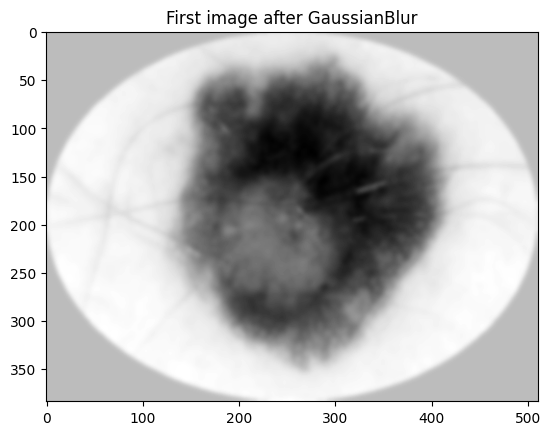

In [123]:
# Display the first image
plt.imshow(train_images[3][3][0], cmap='gray')
plt.title('First image after GaussianBlur')
plt.show()

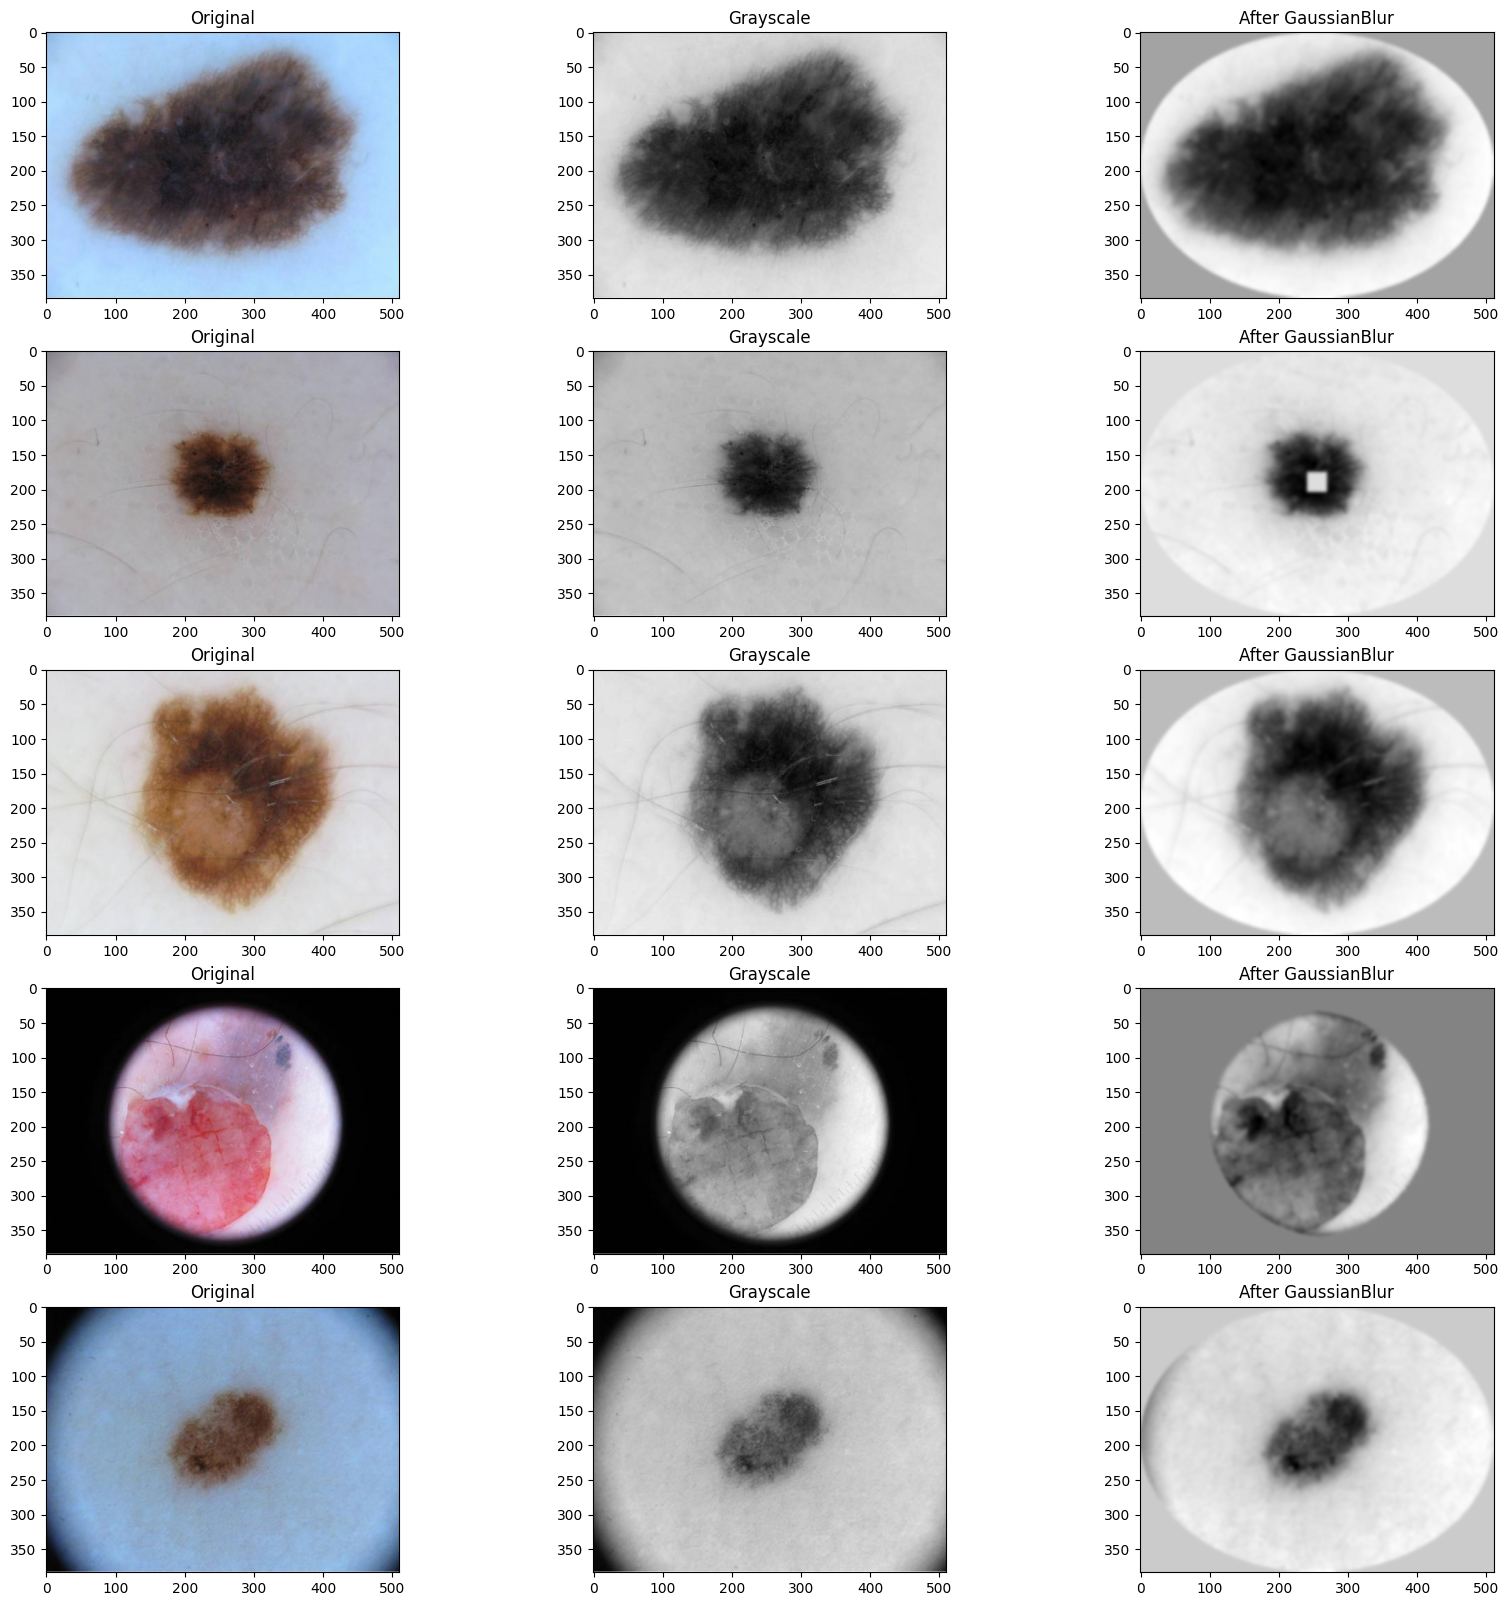

In [124]:
#get the first 5 masks
fig, ax = plt.subplots(5, 3, figsize=(20, 20))

first_5_masks = [mask[0] for mask in train_masks[:5]]

j = 0

for i in first_5_masks:
    #Get the image
    image = next((item for item in train_images if item[0] == i), None)
    
    ax[j, 0].imshow(image[1])
    ax[j, 0].set_title(f'Original')

    ax[j, 1].imshow(image[2], cmap='gray')
    ax[j, 1].set_title(f'Grayscale')

    ax[j, 2].imshow(image[3][0], cmap='gray')
    ax[j, 2].set_title(f'After GaussianBlur')

    j += 1

plt.show()

## Segmentation

In [125]:
# #Get the largest connected component
# def get_largest_connected_component(image):
#     #Get the connected components
#     labels, num_labels = ndi.label(image)
    
#     #Get the sizes of the connected components
#     sizes = np.bincount(labels.flatten())
    
#     #Get the largest connected component
#     largest_component = np.argmax(sizes[1:]) + 1
    
#     #Get the mask of the largest connected component
#     largest_component_mask = labels == largest_component
    
#     return largest_component_mask

# def segment_image(image):
#     #Get the otsu threshold
#     threshold = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    
    
#     segmentation = 1*(image > threshold)

#     segmentation = get_largest_connected_component(segmentation)

#     return segmentation

In [126]:
def watershed_segmentation(image):
    # Apply Otsu's thresholding
    thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    # Perform watershed segmentation
    distance = ndi.distance_transform_edt(thresh)
    markers = ndi.label(thresh)[0]
    labels = watershed(-distance, markers, mask=thresh)
    
    return labels


def thresholding_segmentation(image):
    # Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    return thresh

def kmeans_segmentation(image, n_clusters=2):

    
    # Reshape the image (the image is grayscale)
    reshaped_image = image.reshape(-1, 1)

    # Standardize features by removing the mean and scaling to unit variance
    scaler = StandardScaler()
    scaled_image = scaler.fit_transform(reshaped_image)
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto', max_iter=400, random_state=0)
    kmeans.fit(scaled_image)
    # Reshape labels into image shape
    segmented_image = kmeans.labels_.reshape(image.shape[:2])
    return segmented_image

def get_chan_vese(image):
    return chan_vese(image, mu=0.25, lambda1=1, lambda2=1, tol=1e-3,
               max_num_iter=200, dt=0.5, init_level_set="checkerboard",
               extended_output=True)

In [127]:
#Get the largest connected component
def get_largest_connected_component(image):
    #Get the connected components
    labels, num_labels = ndi.label(image)
    
    #Get the sizes of the connected components
    sizes = np.bincount(labels.flatten())
    
    #Get the largest connected component
    largest_component = np.argmax(sizes[1:]) + 1
    
    #Get the mask of the largest connected component
    largest_component_mask = labels == largest_component
    
    return largest_component_mask

def segment_image(image_mask):
    #Get the otsu threshold
    #image = image[mask != 255]
    image = image_mask[0]
    mask = image_mask[1]

    threshold = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    
    #I have a mask of the background, I will use it to segment the image, I need to put the threshlod only in the 
    #region of the image that is not the background and put the background to black
    threshold[mask == 255] = 255

    #Get the segmentation of the image 1 if the pixel > threshold, 0 otherwise
    segmentation = (image > threshold).astype(np.uint8)
    
    segmentation = get_largest_connected_component(segmentation)

    return segmentation

In [128]:
def get_segmentation(image):
        return [image[0], image[1], image[2], image[3], segment_image(image[3])]

def joblib_segmentation(images):
    return Parallel(n_jobs=-2, verbose=1)(delayed(get_segmentation)(image) for image in images)

#Apply the Chan-Vese segmentation to the images
train_images = joblib_segmentation(train_images)
test_images = joblib_segmentation(test_images)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 127 concurrent workers.


[Parallel(n_jobs=-2)]: Done 196 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-2)]: Done 800 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-2)]: Done 1250 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-2)]: Done 1800 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-2)]: Done 2450 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-2)]: Done 3200 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-2)]: Done 4050 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-2)]: Done 5000 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-2)]: Done 6050 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-2)]: Done 7200 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-2)]: Done 8450 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-2)]: Done 9800 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-2)]: Done 11250 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-2)]: Done 12800 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-2)]: Done 14450 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done 16200 tasks      | elapsed

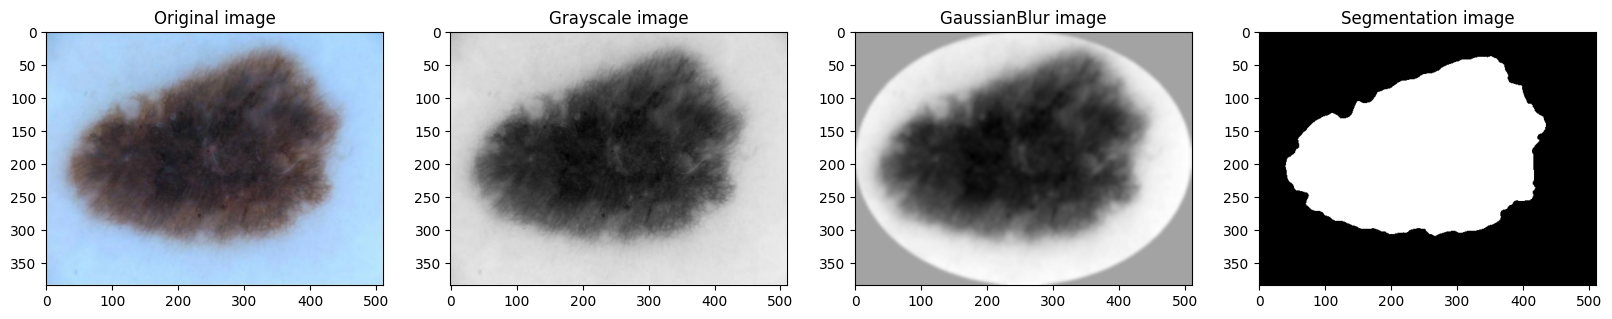

In [129]:
#plot the original image, the gray, the blur and the segmentation
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].imshow(train_images[0][1])
ax[0].set_title('Original image')

ax[1].imshow(train_images[0][2], cmap='gray')
ax[1].set_title('Grayscale image')

ax[2].imshow(train_images[0][3][0], cmap='gray')
ax[2].set_title('GaussianBlur image')

ax[3].imshow(train_images[0][4], cmap='gray')
ax[3].set_title('Segmentation image')

plt.show()

## Image Postprocessing

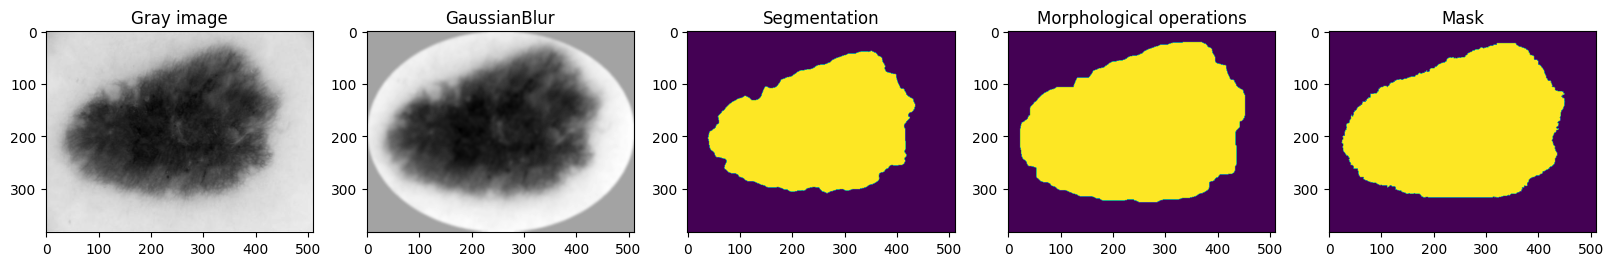

In [130]:
#morphological operations
def get_morphological_operations(image):
    # Convert the image to the appropriate data type
    image = image.astype(np.uint8)

    # # Morphological opening
    # kernel = np.ones((2, 2), np.uint8)
    # opening = cv2.morphologyEx(image, cv2.MORPH_OPEN , kernel)

    # Morphological closing
    kernel = np.ones((35, 35), np.uint8)
    closing = cv2.morphologyEx(image, cv2.MORPH_DILATE, kernel)

    return closing

#Apply the morphological operations to the images and different segmentations

image = train_images[0]
mask = train_masks[0]
image = [image[0], image[1], image[2], image[3], image[4], get_morphological_operations(image[4])]

#plot the original image, the gray, the blur and the segmentation
fig, ax = plt.subplots(1, 5, figsize=(20, 5))

ax[0].imshow(image[2], cmap='gray')
ax[0].set_title('Gray image')

ax[1].imshow(image[3][0], cmap='gray')
ax[1].set_title('GaussianBlur')

ax[2].imshow(image[4])
ax[2].set_title('Segmentation')

ax[3].imshow(image[5])
ax[3].set_title('Morphological operations')

ax[4].imshow(mask[1])
ax[4].set_title('Mask')


plt.show()

In [131]:
# #morphological operations
# def get_morphological_operations(image):
#     # Convert the image to the appropriate data type
#     image = image.astype(np.uint8)

#     # Morphological opening
#     kernel = np.ones((2, 2), np.uint8)
#     opening = cv2.morphologyEx(image, cv2.MORPH_DILATE , kernel)

#     # Morphological closing
#     kernel = np.ones((5, 5), np.uint8)
#     closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

#     return closing

#morphological operations
def get_morphological_operations(image):
    # Convert the image to the appropriate data type
    image = image.astype(np.uint8)

    # # Morphological opening
    # kernel = np.ones((2, 2), np.uint8)
    # opening = cv2.morphologyEx(image, cv2.MORPH_OPEN , kernel)

    # Morphological closing
    kernel = np.ones((35, 35), np.uint8)
    closing = cv2.morphologyEx(image, cv2.MORPH_DILATE, kernel)

    return closing

#Apply the morphological operations to the images and different segmentations

train_images =  [
                    [   image[0], image[1], image[2], image[3], image[4], 
                        get_morphological_operations(image[4]),
                    ] 
                  for image in train_images]

test_images =   [
                    [
                        image[0], image[1], image[2], image[3], image[4],
                        get_morphological_operations(image[4])
                    ] 
                  for image in test_images]

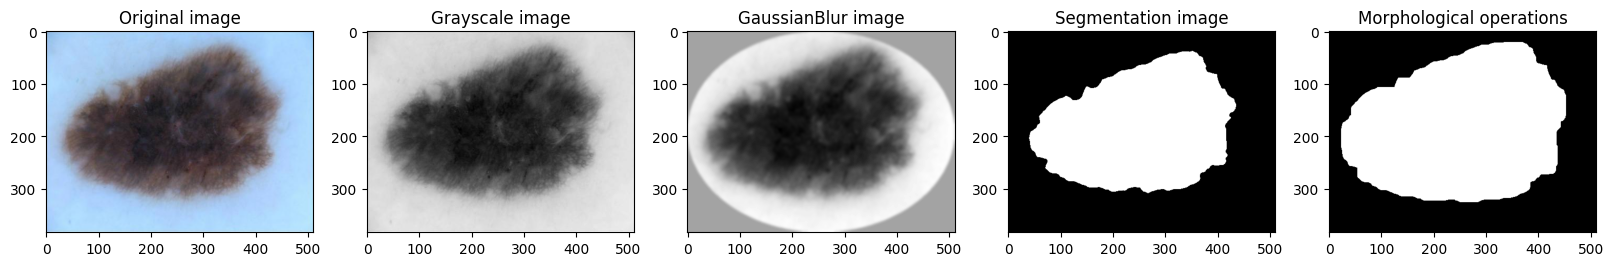

In [ ]:
#plot the original image, the gray, the blur and the segmentation
fig, ax = plt.subplots(1, 5, figsize=(20, 5))

ax[0].imshow(train_images[0][1])
ax[0].set_title('Original image')

ax[1].imshow(train_images[0][2], cmap='gray')
ax[1].set_title('Grayscale image')

ax[2].imshow(train_images[0][3][0], cmap='gray')
ax[2].set_title('GaussianBlur image')

ax[3].imshow(train_images[0][4], cmap='gray')
ax[3].set_title('Segmentation image')

ax[4].imshow(train_images[0][5], cmap='gray')
ax[4].set_title('Morphological operations')

plt.show()

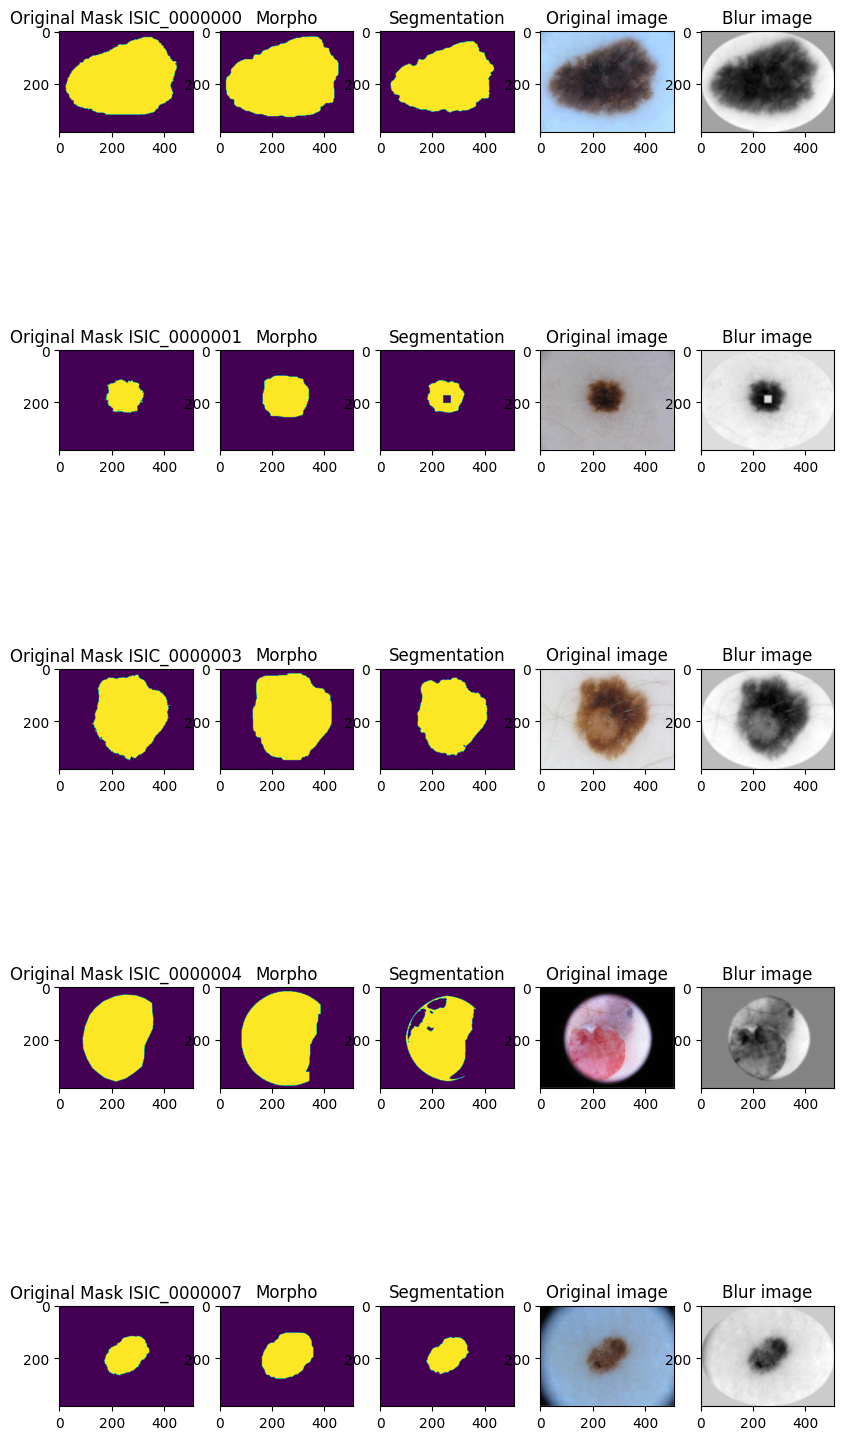

In [ ]:
#comparison of the original masks and the segmented ones
fig, ax = plt.subplots(5, 5, figsize=(10, 20))

#get the first 5 masks
first_5_masks = [mask[0] for mask in train_masks[:5]]

j = 0

for i in first_5_masks:
    #Get the image
    image = next((item for item in train_images if item[0] == i), None)
    #Get the mask
    mask = next((item for item in train_masks if item[0] == i), None)
    
    #Get the class
    class_ = train_data[train_data['ID'] == i]['CLASS'].values[0]
    
    #Plot the original mask
    ax[j, 0].imshow(mask[1])
    ax[j, 0].set_title(f'Original Mask {mask[0]}')
    
    #Plot the segmented mask
    ax[j, 1].imshow(image[5])
    ax[j, 1].set_title(f'Morpho')

    #Plot the segmented mask
    ax[j, 2].imshow(image[4])
    ax[j, 2].set_title(f'Segmentation')


    #Plot the original image
    ax[j, 3].imshow(image[1])
    ax[j, 3].set_title(f'Original image')

    #Plot the blur image
    ax[j, 4].imshow(image[3][0], cmap='gray')
    ax[j, 4].set_title(f'Blur image')

    j += 1

plt.show()

## Dice Coefficient

In [ ]:
#GET THE IMAGE THAT ARE IN MASK AND NOT IN IMAGES
mask_images = [mask[0] for mask in train_masks]
images = [image[0] for image in train_images]

mask_images = set(mask_images)
images = set(images)

no_correspondance = mask_images - images

no_correspondance


set()

In [ ]:
#Dice score between the original masks and the segmented ones
def dice_score(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    return 2 * intersection.sum() / (mask1.sum() + mask2.sum())

dice_scores = []
dice_scores_chan_vese = []
dice_scores_watershed = []
dice_scores_thresholding = []
dice_scores_kmeans = []



for mask in train_masks:
    
        #The image in the original mask
        mask_original = mask[1]
        mask_original[mask_original == 255] = 1
        #The segmented mask
        mask_segmented = next((item for item in train_images if item[0] == mask[0]), None)
        
    
        dice_scores.append(dice_score(mask_original, mask_segmented[5]))

for mask in test_masks:
    #The image in the original mask
    mask_original = mask[1]
    mask_original[mask_original == 255] = 1
    #The segmented mask
    mask_segmented = next((item for item in test_images if item[0] == mask[0]), None)

    dice_scores.append(dice_score(mask_original, mask_segmented[5]))

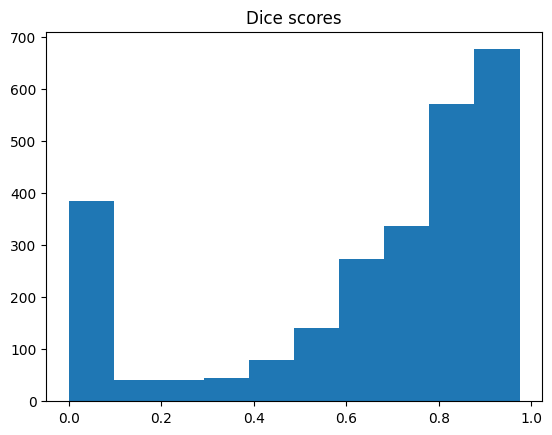

In [ ]:
#Plot the dice scores
plt.hist(dice_scores)
plt.title('Dice scores')

plt.show()

In [ ]:
#Mean of the dice scores
print(f'Mean Dice score: {np.mean(dice_scores)}')

#Percentage of the dice scores greater than 0.8
print(f'Percentage of Dice scores greater than 0.8: {np.mean(np.array(dice_scores) > 0.8)}')


Mean Dice score: 0.6427696835193866
Percentage of Dice scores greater than 0.8: 0.44620131122252216


In [ ]:
#Get the amount of dice score = 0
print(f'Amount of dice score = 0: {np.sum(np.array(dice_scores) < 0.2)}')

#Get the amount of dice score = 1
print(f'Amount of dice score = 1: {np.sum(np.array(dice_scores) > 0)}')


Amount of dice score = 0: 427
Amount of dice score = 1: 2290


## Border Detection

In [ ]:
#Find contours in the segmented masks
def get_contours(image):
    contours, _ = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

train_images =  [[image[0], image[1], image[2], image[3], image[4], image[5], get_contours(image[5])] for image in train_images]
test_images =   [[image[0], image[1], image[2], image[3], image[4], image[5], get_contours(image[5])] for image in test_images]

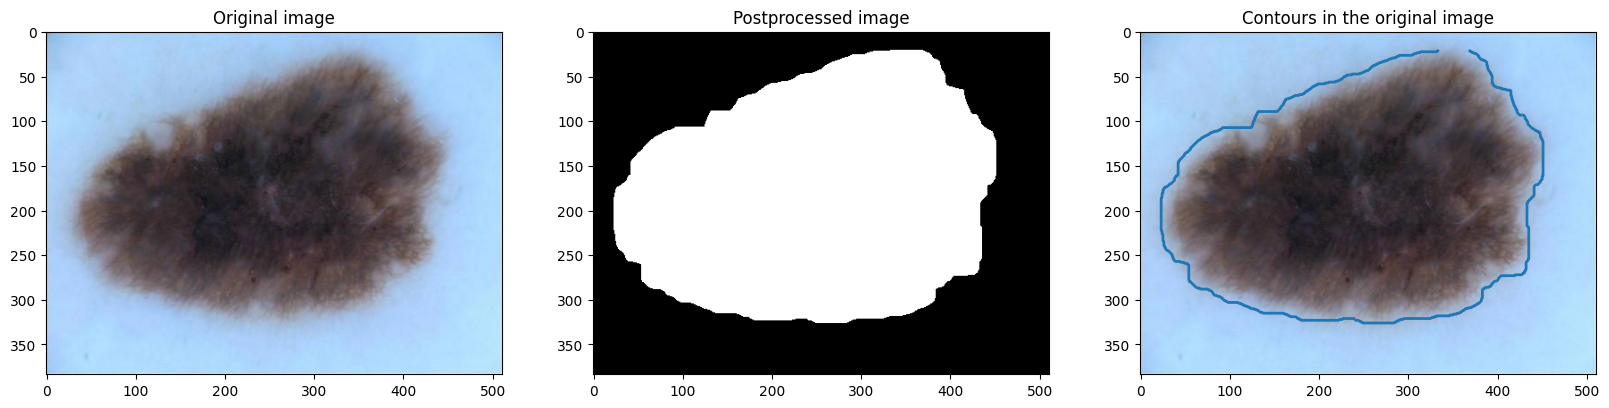

In [ ]:
#Plot the original ilage, the postprocessed, and the contours in the original one
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].imshow(train_images[0][1])
ax[0].set_title('Original image')

ax[1].imshow(train_images[0][5], cmap='gray')
ax[1].set_title('Postprocessed image')

ax[2].imshow(train_images[0][1])
ax[2].set_title('Contours in the original image')
for contour in train_images[0][6]:
    ax[2].plot(contour[:, 0, 0], contour[:, 0, 1], linewidth=2)

plt.show()

## Feature Extraction

The ABCD rule is a method to evaluate the risk of a skin lesion being a melanoma. It is based on the following features:
- **A**symmetry
- **B**order irregularity
- **C**olour
- **D**imension

In [ ]:
train_images_features = []
test_images_features = []

### Asymmetry




In [ ]:
# Function to calculate the distance between two points
def distance(p1, p2):
    return np.sqrt((p1[0][0] - p2[0][0])**2 + (p1[0][1] - p2[0][1])**2)

def longest_diagonal(lesion_boundary):

    # Initialize the maximum diagonal length and coordinates
    max_diag_length = 0
    max_diag_coords = (0, 0, 0, 0)

    # Find the longest diagonal by checking distances between all pairs of points
    for i in range(len(lesion_boundary)):
        for j in range(i+1, len(lesion_boundary)):
            diag_length = distance(lesion_boundary[i], lesion_boundary[j])
            if diag_length > max_diag_length:
                max_diag_length = diag_length
                max_diag_coords = lesion_boundary[i], lesion_boundary[j]

    return max_diag_coords

def calculate_assymetry_features(image):
    # Assuming the largest contour corresponds to the lesion boundary
    # This will be a list of (row, col) coordinates of the boundary pixels
    lesion_boundary = max(image[6], key=len)

    # Find the longest diagonal of the lesion
    max_diag_coords = longest_diagonal(lesion_boundary)
    
    # Define the number of perpendicular lines
    N = 10
    T = len(lesion_boundary)
    P = T / N
    
    # Calculate the distances from points on the diagonal to the lesion boundary
    diagonal_length = np.linalg.norm(max_diag_coords[0] - max_diag_coords[1])
    step_size = diagonal_length / N
    distances = []
    for i in range(N):
        point_on_diagonal = max_diag_coords[0] + (max_diag_coords[1] - max_diag_coords[0]) * (i * step_size / diagonal_length)
        perp_distances = [np.linalg.norm(point_on_diagonal - contour_point) for contour_point in lesion_boundary]
        distances.append((min(perp_distances), max(perp_distances)))
    
    # Compute the features
    ratios = [d[0] / d[1] if d[1] != 0 else 0 for d in distances]
    std_dev = np.std(ratios)
    
    assymetry_features = { 'std_dev': std_dev, 'ratios': ratios}
 
    #Assymetry features in that format
    assymetry_features = { 'std_dev': std_dev }
    assymetry_features.update({ f'ratio_{i}': val for i, val in enumerate(ratios) })
    
    # Return the features in a dictionary
    return assymetry_features


### Border Irregularity

In [ ]:
def calculate_border_irregularity_features(border):
    """
    Calculate border irregularity features based on the inflection points and vector product descriptors.
    
    :param border: A numpy array of the contour points of the lesion border.
    :return: A dictionary with counts of peaks, valleys, and straight lines for both small and large irregularities.
    """
    border = border[:, 0, :]
        
    # Initialize the counts for small irregularities
    small_irregularities = {'peaks': 0, 'valleys': 0, 'straight_lines': 0}

    # Initialize the counts for large irregularities
    large_irregularities = {'peaks': 0, 'valleys': 0, 'straight_lines': 0}

    # Inflection point descriptor parameters
    T1 = 2
    T2 = -2

    # Calculate small irregularities based on inflection points
    for i in range(1, len(border) - 1):
        # Get the neighbors
        left_neighbor = border[i - 1]
        right_neighbor = border[i + 1]

        # Calculate the weights (y-axis difference)
        Wl = left_neighbor[1] - border[i][1]
        Wr = right_neighbor[1] - border[i][1]

        # Sum the weights
        S = Wl + Wr

        # Determine if it's a peak, valley, or straight line based on the weight sum
        if S > T1:
            small_irregularities['peaks'] += 1
        elif S < T2:
            small_irregularities['valleys'] += 1
        else:
            small_irregularities['straight_lines'] += 1

    # Function to calculate vector product V for three points p1, p2, p3
    def vector_product(p1, p2, p3):
        (x1, y1), (x2, y2), (x3, y3) = p1, p2, p3
        return (x2 - x1) * (y3 - y1) - (y2 - y1) * (x3 - x1)

    # Calculate large irregularities based on vector products
    for i in range(15,len(border)-15):
        # Ensure circular indexing at the borders
        p1 = border[i - 15]
        p2 = border[i]
        p3 = border[(i + 15)]

        # Calculate the vector product
        V = vector_product(p1, p2, p3)

        # Determine if it's a peak, valley, or straight line based on vector product
        if V > 0:
            large_irregularities['peaks'] += 1
        elif V < 0:
            large_irregularities['valleys'] += 1
        else:
            large_irregularities['straight_lines'] += 1

    

    # Return the calculated features in a dictionary
    return small_irregularities, large_irregularities


### Colour

In [ ]:
def calculate_color_features(image):
    """
    Calculate color features for an image in the RGB color space.
    
    :param image: RGB image as a numpy array.
    :return: A dictionary with the mean, variance, and standard deviation for each RGB channel.
    """
    color_features = {}
    # Split the image into R, G, and B channels
    R, G, B = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    
    # Calculate the mean, variance, and standard deviation for each channel
    color_features['mean_R'] = np.mean(R)
    color_features['mean_G'] = np.mean(G)
    color_features['mean_B'] = np.mean(B)
    
    color_features['variance_R'] = np.var(R)
    color_features['variance_G'] = np.var(G)
    color_features['variance_B'] = np.var(B)
    
    color_features['std_dev_R'] = np.std(R)
    color_features['std_dev_G'] = np.std(G)
    color_features['std_dev_B'] = np.std(B)
    
    return color_features

### Dimension

In [ ]:
def calculate_fractal_dimension(image):
    """
    Calculate the fractal dimension of an image using the box-counting method.
    
    :param image: Mask image as a numpy array.
    :return: The fractal dimension D of the image.
    """

    # Box-counting implementation
    def boxcount(binary_image, k):

        S = np.add.reduceat(
                np.add.reduceat(binary_image, 
                                np.arange(0, binary_image.shape[0], k), axis=0),
                np.arange(0, binary_image.shape[1], k), axis=1)
        
        return len(np.where(S > 0)[0])

    # Fractal dimension calculation
    p = min(image.shape)
    n = 2**np.floor(np.log(p)/np.log(2))
    n = int(np.log(n)/np.log(2))
    sizes = 2**np.arange(n, 1, -1)
    counts = []
    for size in sizes:
        counts.append(boxcount(image, size))

    if len(sizes) > 0 and len(counts) > 0:
        coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    else:
        coeffs = np.array([0, 0])

    return -coeffs[0] if len(coeffs) > 0 else 0


In [ ]:
def calculate_texture_features(image):
    """
    Calculate the texture features of an image.
    
    :param image_path: mask image.
    :return: A dictionary with the calculated texture features.
    """
    
    # Calculate the fractal dimension of the whole image
    D = calculate_fractal_dimension(image)

    # Calculate the fractal dimension of 16 parts of the image
    rows, cols = image.shape
    step_r, step_c = rows // 4, cols // 4
    D_parts = []
    for i in range(0, rows, step_r):
        for j in range(0, cols, step_c):
            part = image[i:i+step_r, j:j+step_c]
            
            D_parts.append(calculate_fractal_dimension(part))
    
    # Calculate the image-based fractal dimension D2
    D2 = np.mean(D_parts) + 1
    
    # Create a dictionary to store the texture features
    texture_features = {
        'fractal_dimension_total': D,
        'fractal_dimensions_parts': D_parts,
        'fractal_dimension_D2': D2
    }

    # Return the features in a dictionary
    texture_features = { 'fractal_dimension_total': D }
    texture_features.update({ f'fractal_dimension_part_{i}': val for i, val in enumerate(D_parts) })
    texture_features['fractal_dimension_D2'] = D2
    
    return texture_features

### Add features

In [ ]:
def get_features(image):
    
    id = {'ID':image[0]}
    assymetry_features = calculate_assymetry_features(image)
    small_irregularities, large_irregularities = calculate_border_irregularity_features(image[6][0])
    color_features = calculate_color_features(image[1])
    #texture_features = calculate_texture_features(image[5])

    
    # Return the features in a dictionary
    #return {**id, **assymetry_features, **small_irregularities, **large_irregularities, **color_features, **texture_features}
    return {**id, **assymetry_features, **small_irregularities, **large_irregularities, **color_features}

def joblib_features(images):
    return Parallel(n_jobs=-2, verbose=1)(delayed(get_features)(image) for image in images)

train_images_features = joblib_features(train_images)
test_images_features = joblib_features(test_images)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 127 concurrent workers.
[Parallel(n_jobs=-2)]: Done 196 tasks      | elapsed:    1.4s


[Parallel(n_jobs=-2)]: Done 838 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-2)]: Done 1377 tasks      | elapsed:    6.1s


KeyboardInterrupt: 

# Final Dataset

In [ ]:
# Create a DataFrame with the calculated features and the features from the metadata
train_features_df = pd.DataFrame(train_images_features)
test_features_df = pd.DataFrame(test_images_features)

# Merge the metadata with the calculated features on ID, but I need to conserve the ID
train_data = pd.merge(train_data, train_features_df, on='ID')
test_data = pd.merge(test_data, test_features_df, on='ID')

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18998 entries, 0 to 18997
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              18998 non-null  object 
 1   CLASS           18998 non-null  int64  
 2   SEX             18714 non-null  object 
 3   AGE             18674 non-null  float64
 4   POSITION        17028 non-null  object 
 5   std_dev         18998 non-null  float64
 6   ratio_0         18998 non-null  float64
 7   ratio_1         18998 non-null  float64
 8   ratio_2         18998 non-null  float64
 9   ratio_3         18998 non-null  float64
 10  ratio_4         18998 non-null  float64
 11  ratio_5         18998 non-null  float64
 12  ratio_6         18998 non-null  float64
 13  ratio_7         18998 non-null  float64
 14  ratio_8         18998 non-null  float64
 15  ratio_9         18998 non-null  float64
 16  peaks           18998 non-null  int64  
 17  valleys         18998 non-null 

In [ ]:
train_features_df.head()

,ID,std_dev,ratio_0,ratio_1,ratio_2,ratio_3,ratio_4,ratio_5,ratio_6,ratio_7,...,straight_lines,mean_R,mean_G,mean_B,variance_R,variance_G,variance_B,std_dev_R,std_dev_G,std_dev_B
0,ISIC_0000000,0.155789,0.0,0.105835,0.213970,0.257987,0.363196,0.507223,0.454135,0.360248,...,3,130.670525,147.115847,169.391522,2432.988972,5050.645663,7500.578222,49.325338,71.067895,86.605879
1,ISIC_0000001,0.220132,0.0,0.101361,0.197584,0.333973,0.530520,0.718140,0.554313,0.388203,...,1,165.150094,161.018244,164.498899,696.585838,1017.958500,1314.606326,26.392913,31.905462,36.257500
2,ISIC_0000002,0.177931,0.0,0.101375,0.203576,0.324537,0.449306,0.556893,0.461686,0.313314,...,0,134.738075,149.348214,186.191633,858.053174,2035.739905,4372.321220,29.292545,45.119174,66.123530
3,ISIC_0000003,0.147046,0.0,0.102494,0.147146,0.237935,0.357425,0.461923,0.424864,0.356970,...,2,189.417589,175.357454,167.108188,2012.456424,3766.213454,5283.609692,44.860410,61.369483,72.688443
4,ISIC_0000004,0.287624,0.0,0.108942,0.247078,0.424877,0.662151,0.961024,0.662177,0.425401,...,0,89.513739,67.399732,79.040444,9167.349157,5770.532928,7610.073605,95.746275,75.964024,87.235736


In [ ]:
train_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18998 entries, 0 to 18997
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              18998 non-null  object 
 1   std_dev         18998 non-null  float64
 2   ratio_0         18998 non-null  float64
 3   ratio_1         18998 non-null  float64
 4   ratio_2         18998 non-null  float64
 5   ratio_3         18998 non-null  float64
 6   ratio_4         18998 non-null  float64
 7   ratio_5         18998 non-null  float64
 8   ratio_6         18998 non-null  float64
 9   ratio_7         18998 non-null  float64
 10  ratio_8         18998 non-null  float64
 11  ratio_9         18998 non-null  float64
 12  peaks           18998 non-null  int64  
 13  valleys         18998 non-null  int64  
 14  straight_lines  18998 non-null  int64  
 15  mean_R          18998 non-null  float64
 16  mean_G          18998 non-null  float64
 17  mean_B          18998 non-null 

# Classification

### Preprocessing Data

In [ ]:
#Fill null age with mean
train_data['AGE'] = train_data['AGE'].fillna(train_data['AGE'].mean())
test_data['AGE'] = test_data['AGE'].fillna(test_data['AGE'].mean())


#Fill null POSITION with NO POSTION
train_data['POSITION'] = train_data['POSITION'].fillna('NO POSITION')
test_data['POSITION'] = test_data['POSITION'].fillna('NO POSITION')

#One hot encoding SEX and POSITION
train_data = pd.get_dummies(train_data, columns=['SEX','POSITION'])
test_data = pd.get_dummies(test_data, columns=['SEX','POSITION'])

#Drop the ID column
train_data = train_data.drop(columns='ID')

#SAVE THE DATA IN CSV
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

#test_data = test_data.drop(columns='ID')


In [ ]:
#UPLOAD THE DATA FROM CSV
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

In [ ]:

#Split the data
X_train, X_test, y_train, y_test = train_test_split(train_data.drop(columns='CLASS'), train_data['CLASS'], test_size=0.2, random_state=42)

# X_train = train_data.drop(columns='CLASS')
# y_train = train_data['CLASS']

# X_test = test_data

#Normalize and scale data
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
#Custom Scorer for the weighted accuracy

weights = [ 0.7005531, 0.24592265, 0.95261733, 3.64804147, 1.20674543, 13.19375, 12.56547619, 5.04219745]
def weighted_accuracy(y_true, y_pred):
    
    # Calculate the weighted accuracy
    weighted_accuracy = 0
    for i in range(len(weights)):
        weighted_accuracy += weights[i] * (y_true == y_pred).mean()
    
    return weighted_accuracy

In [ ]:
#SVM

#Grid search
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']}
grid_svm = GridSearchCV(SVC(), param_grid, refit=True, verbose=3, scoring=make_scorer(weighted_accuracy))
grid_svm.fit(X_train, y_train)

print(grid_svm.best_params_)
print(grid_svm.best_estimator_)

#Predictions
grid_predictions_svm = grid_svm.predict(X_test)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[CV 1/5] END .......C=0.1, gamma=1, kernel=rbf;, score=21.656 total time=   7.9s
[CV 2/5] END .......C=0.1, gamma=1, kernel=rbf;, score=21.471 total time=   7.8s
[CV 3/5] END .......C=0.1, gamma=1, kernel=rbf;, score=21.545 total time=   7.8s
[CV 4/5] END .......C=0.1, gamma=1, kernel=rbf;, score=21.886 total time=   7.8s
[CV 5/5] END .......C=0.1, gamma=1, kernel=rbf;, score=21.404 total time=   7.7s
[CV 1/5] END .....C=0.1, gamma=0.1, kernel=rbf;, score=21.990 total time=   7.1s
[CV 2/5] END .....C=0.1, gamma=0.1, kernel=rbf;, score=21.360 total time=   7.1s
[CV 3/5] END .....C=0.1, gamma=0.1, kernel=rbf;, score=21.421 total time=   7.0s
[CV 4/5] END .....C=0.1, gamma=0.1, kernel=rbf;, score=21.552 total time=   7.0s
[CV 5/5] END .....C=0.1, gamma=0.1, kernel=rbf;, score=21.441 total time=   7.0s
[CV 1/5] END ....C=0.1, gamma=0.01, kernel=rbf;, score=19.148 total time=   7.0s
[CV 2/5] END ....C=0.1, gamma=0.01, kernel=rbf;, score=19.148 total time=   7.0s
[CV 3/5] END ....C=0.1, gamm

KeyboardInterrupt: 

In [ ]:
#Print the classification report
print(classification_report(y_test, grid_predictions_svm))

#Print weighted accuracy
print(f'Weighted accuracy: {weighted_accuracy(y_test, grid_predictions_svm)}')

              precision    recall  f1-score   support

           1       0.53      0.45      0.49       670
           2       0.73      0.91      0.81      1908
           3       0.46      0.54      0.50       513
           4       0.42      0.16      0.23       135
           5       0.45      0.23      0.31       398
           6       1.00      0.03      0.05        37
           7       0.83      0.22      0.35        45
           8       0.33      0.05      0.09        94

    accuracy                           0.64      3800
   macro avg       0.60      0.32      0.35      3800
weighted avg       0.62      0.64      0.61      3800

Weighted accuracy: 24.074926215347364


In [ ]:
#Random Forest

#Grid search
param_grid = {'n_estimators': [10, 100, 1000], 'max_features': ['sqrt', 'log2']}
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid, refit=True, verbose=3, scoring=make_scorer(weighted_accuracy))
grid_rf.fit(X_train, y_train)

print(grid_rf.best_params_)
print(grid_rf.best_estimator_)

#Predictions
grid_predictions_rf = grid_rf.predict(X_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .................max_features=sqrt, n_estimators=10; total time=   0.6s
[CV] END .................max_features=sqrt, n_estimators=10; total time=   0.5s
[CV] END .................max_features=sqrt, n_estimators=10; total time=   0.5s
[CV] END .................max_features=sqrt, n_estimators=10; total time=   0.6s
[CV] END .................max_features=sqrt, n_estimators=10; total time=   0.5s
[CV] END ................max_features=sqrt, n_estimators=100; total time=   5.4s
[CV] END ................max_features=sqrt, n_estimators=100; total time=   5.3s
[CV] END ................max_features=sqrt, n_estimators=100; total time=   5.4s
[CV] END ................max_features=sqrt, n_estimators=100; total time=   5.3s
[CV] END ................max_features=sqrt, n_estimators=100; total time=   5.3s
[CV] END ...............max_features=sqrt, n_estimators=1000; total time=  53.4s
[CV] END ...............max_features=sqrt, n_esti

In [ ]:
#Print the classification report
print(classification_report(y_test, grid_predictions_rf))

#Print weighted accuracy
print(f'Weighted accuracy: {weighted_accuracy(y_test, grid_predictions_rf)}')


              precision    recall  f1-score   support

           1       0.56      0.46      0.51       670
           2       0.72      0.94      0.81      1908
           3       0.52      0.53      0.52       513
           4       0.56      0.21      0.31       135
           5       0.54      0.25      0.34       398
           6       1.00      0.05      0.10        37
           7       1.00      0.04      0.09        45
           8       1.00      0.03      0.06        94

    accuracy                           0.66      3800
   macro avg       0.74      0.31      0.34      3800
weighted avg       0.65      0.66      0.62      3800

Weighted accuracy: 24.697553617468422


In [ ]:
#Logistic Regression

#Grid search
param_grid = {'C': [0.1, 1, 10, 100]}
grid_lr = GridSearchCV(LogisticRegression(), param_grid, refit=True, verbose=3, scoring=make_scorer(weighted_accuracy))
grid_lr.fit(X_train, y_train)

print(grid_lr.best_params_)
print(grid_lr.best_estimator_)

#Predictions
grid_predictions_lr = grid_lr.predict(X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/infres/jrios-23/IMA205-Kaggle-Challenge-2024-1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ............................C=0.1;, score=22.570 total time=   0.4s


/home/infres/jrios-23/IMA205-Kaggle-Challenge-2024-1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ............................C=0.1;, score=22.064 total time=   0.4s


/home/infres/jrios-23/IMA205-Kaggle-Challenge-2024-1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ............................C=0.1;, score=22.286 total time=   0.4s


/home/infres/jrios-23/IMA205-Kaggle-Challenge-2024-1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ............................C=0.1;, score=23.097 total time=   0.4s


/home/infres/jrios-23/IMA205-Kaggle-Challenge-2024-1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ............................C=0.1;, score=22.293 total time=   0.4s


/home/infres/jrios-23/IMA205-Kaggle-Challenge-2024-1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ..............................C=1;, score=22.669 total time=   0.5s


/home/infres/jrios-23/IMA205-Kaggle-Challenge-2024-1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ..............................C=1;, score=22.249 total time=   0.4s


/home/infres/jrios-23/IMA205-Kaggle-Challenge-2024-1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ..............................C=1;, score=22.471 total time=   0.4s


/home/infres/jrios-23/IMA205-Kaggle-Challenge-2024-1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ..............................C=1;, score=23.109 total time=   0.5s


/home/infres/jrios-23/IMA205-Kaggle-Challenge-2024-1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ..............................C=1;, score=22.541 total time=   0.4s


/home/infres/jrios-23/IMA205-Kaggle-Challenge-2024-1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END .............................C=10;, score=22.669 total time=   0.4s


/home/infres/jrios-23/IMA205-Kaggle-Challenge-2024-1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END .............................C=10;, score=22.348 total time=   0.5s


/home/infres/jrios-23/IMA205-Kaggle-Challenge-2024-1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END .............................C=10;, score=22.459 total time=   0.4s


/home/infres/jrios-23/IMA205-Kaggle-Challenge-2024-1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END .............................C=10;, score=23.035 total time=   0.4s


/home/infres/jrios-23/IMA205-Kaggle-Challenge-2024-1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END .............................C=10;, score=22.442 total time=   0.3s


/home/infres/jrios-23/IMA205-Kaggle-Challenge-2024-1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ............................C=100;, score=22.780 total time=   0.3s


/home/infres/jrios-23/IMA205-Kaggle-Challenge-2024-1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ............................C=100;, score=22.286 total time=   0.3s


/home/infres/jrios-23/IMA205-Kaggle-Challenge-2024-1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ............................C=100;, score=22.336 total time=   0.4s


/home/infres/jrios-23/IMA205-Kaggle-Challenge-2024-1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ............................C=100;, score=23.060 total time=   0.3s


/home/infres/jrios-23/IMA205-Kaggle-Challenge-2024-1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ............................C=100;, score=22.442 total time=   0.3s
{'C': 1}
LogisticRegression(C=1)


/home/infres/jrios-23/IMA205-Kaggle-Challenge-2024-1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
#Print the classification report
print(classification_report(y_test, grid_predictions_lr))

#Print weighted accuracy
print(f'Weighted accuracy: {weighted_accuracy(y_test, grid_predictions_lr)}')

              precision    recall  f1-score   support

           1       0.43      0.43      0.43       670
           2       0.71      0.89      0.79      1908
           3       0.41      0.43      0.42       513
           4       0.46      0.04      0.08       135
           5       0.39      0.18      0.25       398
           6       0.00      0.00      0.00        37
           7       0.00      0.00      0.00        45
           8       0.00      0.00      0.00        94

    accuracy                           0.60      3800
   macro avg       0.30      0.25      0.25      3800
weighted avg       0.55      0.60      0.56      3800

Weighted accuracy: 22.57271407054737


/home/infres/jrios-23/IMA205-Kaggle-Challenge-2024-1/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/infres/jrios-23/IMA205-Kaggle-Challenge-2024-1/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/infres/jrios-23/IMA205-Kaggle-Challenge-2024-1/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

In [ ]:
#KNN

#Grid search
param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15]}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid, refit=True, verbose=3, scoring=make_scorer(weighted_accuracy))
grid_knn.fit(X_train, y_train)

print(grid_knn.best_params_)
print(grid_knn.best_estimator_)

#Predictions
grid_predictions_knn = grid_knn.predict(X_test)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ....................n_neighbors=1;, score=21.705 total time=   0.3s
[CV 2/5] END ....................n_neighbors=1;, score=21.372 total time=   0.0s
[CV 3/5] END ....................n_neighbors=1;, score=22.224 total time=   0.0s
[CV 4/5] END ....................n_neighbors=1;, score=21.638 total time=   0.0s
[CV 5/5] END ....................n_neighbors=1;, score=21.799 total time=   0.0s
[CV 1/5] END ....................n_neighbors=3;, score=21.854 total time=   0.0s
[CV 2/5] END ....................n_neighbors=3;, score=21.755 total time=   0.0s
[CV 3/5] END ....................n_neighbors=3;, score=22.224 total time=   0.0s
[CV 4/5] END ....................n_neighbors=3;, score=22.034 total time=   0.0s
[CV 5/5] END ....................n_neighbors=3;, score=21.972 total time=   0.0s
[CV 1/5] END ....................n_neighbors=5;, score=22.410 total time=   0.0s
[CV 2/5] END ....................n_neighbors=5;, 

In [ ]:
#Print the classification report
print(classification_report(y_test, grid_predictions_knn))

#Print weighted accuracy
print(f'Weighted accuracy: {weighted_accuracy(y_test, grid_predictions_knn)}')

              precision    recall  f1-score   support

           1       0.46      0.36      0.40       670
           2       0.68      0.90      0.78      1908
           3       0.40      0.38      0.39       513
           4       0.22      0.14      0.17       135
           5       0.34      0.16      0.22       398
           6       0.67      0.05      0.10        37
           7       0.00      0.00      0.00        45
           8       0.22      0.02      0.04        94

    accuracy                           0.59      3800
   macro avg       0.37      0.25      0.26      3800
weighted avg       0.53      0.59      0.54      3800

Weighted accuracy: 22.088448313342102


/home/infres/jrios-23/IMA205-Kaggle-Challenge-2024-1/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/infres/jrios-23/IMA205-Kaggle-Challenge-2024-1/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/infres/jrios-23/IMA205-Kaggle-Challenge-2024-1/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

In [ ]:
# Tensorflow Neural Network

#Create the model
model = Sequential()
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Train the model
model.fit(X_train, y_train, epochs=150, batch_size=10)

#Predictions
y_pred = model.predict(X_test)


Epoch 1/150
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 3s 586us/step - accuracy: 0.1754 - loss: -809.0709
Epoch 2/150
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 1s 529us/step - accuracy: 0.1745 - loss: -25748.7988
Epoch 3/150
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 1s 582us/step - accuracy: 0.1779 - loss: -113991.1562
Epoch 4/150
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 1s 571us/step - accuracy: 0.1772 - loss: -286308.5625
Epoch 5/150
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - accuracy: 0.1734 - loss: -551031.3125
Epoch 6/150
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 1s 571us/step - accuracy: 0.1800 - loss: -916779.7500
Epoch 7/150
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 1s 565us/step - accuracy: 0.1802 - loss: -1386825.1250
Epoch 8/150
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 1s 575us/step - accuracy: 0.1762 - loss: -2034960.7500
Epoch 9/150
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 1s 520us/step - accuracy: 0.1807 - loss: -2764657.5000
Epoch 10/150
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 1s 574us/step - accuracy: 0.1864 - loss: -3707728.2500
Epoch 11/150
1520/1520 ━━━━━━

In [ ]:
#Print the classification report
print(classification_report(y_test, y_pred))

#Print weighted accuracy
print(f'Weighted accuracy: {weighted_accuracy(y_test, y_pred)}')

              precision    recall  f1-score   support

           1       0.18      1.00      0.30       670
           2       0.00      0.00      0.00      1908
           3       0.00      0.00      0.00       513
           4       0.00      0.00      0.00       135
           5       0.00      0.00      0.00       398
           6       0.00      0.00      0.00        37
           7       0.00      0.00      0.00        45
           8       0.00      0.00      0.00        94

    accuracy                           0.18      3800
   macro avg       0.02      0.12      0.04      3800
weighted avg       0.03      0.18      0.05      3800



/home/infres/jrios-23/IMA205-Kaggle-Challenge-2024-1/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/infres/jrios-23/IMA205-Kaggle-Challenge-2024-1/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/infres/jrios-23/IMA205-Kaggle-Challenge-2024-1/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

ValueError: Data must be 1-dimensional, got ndarray of shape (3800, 3800) instead

# Metrics
As ranking metric, we will use the Weighted Categorization Accuracy which is defined as:
$$WA=1N∑i=1NwiI(yi=fi)$$
such that
$$∑i=1Nwi=N$$
in order to keep the maximum value equal to 1

where $y_i$ are ground truths, $f_i$ are the predicted results, and $w_i$ are the weights of the $i-th$ test image. If we make the hypothesis that we have $K$ groups - or classes - called $G={G_1,…,G_K}$ and we associate the same weight $w_t$ to all images of the same group $t$, we obtain that the weights are equal to: $w_t = \frac{ N }{ k |G_t|}$

In this way, we can take into account the imbalance nature of the data-set, if present.
Please note that the class weights in the test set are equal to: [ 0.7005531 0.24592265 0.95261733 3.64804147 1.20674543 13.19375 12.56547619 5.04219745]

In [ ]:
#Calculate the weighted accuracy for every prediction to get the best model
#$$WA=1N∑i=1NwiI(yi=fi)$$

# #SVM
# print(classification_report(y_test, grid_predictions_svm))
# print(confusion_matrix(y_test, grid_predictions_svm))
# print(weighted_accuracy(y_test, grid_predictions_svm))

# #Random Forest
# print(classification_report(y_test, grid_predictions_rf))
# print(confusion_matrix(y_test, grid_predictions_rf))
# print(weighted_accuracy(y_test, grid_predictions_rf))

# #Logistic Regression
# print(classification_report(y_test, grid_predictions_lr))
# print(confusion_matrix(y_test, grid_predictions_lr))
# print(weighted_accuracy(y_test, grid_predictions_lr))

# #KNN
# print(classification_report(y_test, grid_predictions_knn))
# print(confusion_matrix(y_test, grid_predictions_knn))
# print(weighted_accuracy(y_test, grid_predictions_knn))

# #Neural Network
# print(classification_report(y_test, y_pred))
# print(confusion_matrix(y_test, y_pred))
# #print(weighted_accuracy(y_test, y_pred))

#Select the best model
#The best model is the one with the highest weighted accuracy


models_results = [grid_svm, grid_rf, grid_lr, grid_knn]
results = [grid_predictions_svm, grid_predictions_rf, grid_predictions_lr, grid_predictions_knn]

best_results = results[np.argmax([weighted_accuracy(y_test, model) for model in results])]
best_model = models_results[np.argmax([weighted_accuracy(y_test, model) for model in results])]

print(best_model)

#predictions for test_data
test_predictions = best_model.predict(test_data.drop(columns='ID'))

#Now I need to put every prediction to the according ID that has in the test data
test_predictions = pd.DataFrame(test_predictions, columns=['CLASS'])
test_predictions = pd.concat([test_data['ID'], test_predictions], axis=1)

#save the predictions
pd.DataFrame(test_predictions, columns=['ID','CLASS']).to_csv('submission.csv', index=False)


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_features': ['sqrt', 'log2'],
                         'n_estimators': [10, 100, 1000]},
             scoring=make_scorer(weighted_accuracy), verbose=2)


/home/infres/jrios-23/IMA205-Kaggle-Challenge-2024-1/venv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [ ]:
train_data

,CLASS,AGE,std_dev,ratio_0,ratio_1,ratio_2,ratio_3,ratio_4,ratio_5,ratio_6,...,SEX_male,POSITION_NO POSITION,POSITION_anterior torso,POSITION_head/neck,POSITION_lateral torso,POSITION_lower extremity,POSITION_oral/genital,POSITION_palms/soles,POSITION_posterior torso,POSITION_upper extremity
0,2,30.0,0.159612,0.0,0.103780,0.182046,0.297003,0.391825,0.528632,0.447323,...,True,True,False,False,False,False,False,False,False,False
1,8,85.0,0.287158,0.0,0.109091,0.247341,0.425057,0.661543,0.960115,0.659720,...,True,False,False,False,False,True,False,False,False,False
2,3,85.0,0.093077,0.0,0.050391,0.111709,0.175871,0.240451,0.302279,0.239487,...,True,False,False,True,False,False,False,False,False,False
3,1,55.0,0.053385,0.0,0.030751,0.082484,0.117400,0.105826,0.154916,0.170123,...,True,False,False,True,False,False,False,False,False,False
4,8,45.0,0.134591,0.0,0.111111,0.056185,0.061877,0.218096,0.457511,0.272481,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18993,2,40.0,0.116695,0.0,0.106769,0.202562,0.254174,0.343257,0.373479,0.339491,...,True,False,False,False,False,False,False,False,True,False
18994,2,30.0,0.143007,0.0,0.103654,0.205074,0.304539,0.395751,0.485411,0.338153,...,True,False,True,False,False,False,False,False,False,False
18995,1,50.0,0.159759,0.0,0.092254,0.161314,0.275090,0.431847,0.526077,0.398147,...,False,False,False,False,False,False,False,False,True,False
18996,2,50.0,0.147946,0.0,0.099512,0.185521,0.305202,0.392952,0.470181,0.414334,...,True,False,False,False,False,True,False,False,False,False


# Conclusions

# References


* http://ieeexplore.ieee.org/document/918473/
* https://www.sciencedirect.com/science/article/pii/S0933365712001108#bib0180
* https://www.sciencedirect.com/science/article/pii/S0957417416302354#bib0023
* https://www.sciencedirect.com/science/article/pii/S0933365713001589
* https://www.nature.com/articles/nature21056
* https://hal-univ-bourgogne.archives-ouvertes.fr/hal-01250955/document
* https://workshop2021.isic-archive.com/
* https://workshop2020.isic-archive.com/#paper